# Data Understanding

## Settings

In [1]:
########################################################################################################################
# Imports & Settings
########################################################################################################################

import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re
import time
import pycountry
from pandas.core.common import flatten
from functools import reduce

In [2]:
# allow display of all rows (with scrollbar)
pd.set_option("display.max_rows", 10) #pd.set_option("display.max_rows", None)

# determine whether to use calculated language flags or recompute them
recompute_lg_flg = False

In [3]:
########################################################################################################################
# User Input
########################################################################################################################

# source data file paths
transactions_path = '../data/external/transactions.csv'
evaluation_path = '../data/external/evaluation.csv'
items_path = '../data/external/items.csv'
subject_cats_0_path = '../data/external/subject_cats_0.csv'

# pre-processed data file paths (incl. language flags)
items_path_pp = '../data/processed/items_pp.csv'
header_items_path_pp = '../data/processed/header_items_pp.csv'

# seaborn color palette
palette_blue = "Blues_d"
dark_blue = "#011f4b"
middle_blue = "#005b96"
light_blue = "#b3cde0"

## Functions

In [4]:
########################################################################################################################
# Functions
########################################################################################################################

def clean_alt_list(list_):
#     list_ = list_.replace(', ', ',')
    list_ = list_.replace('[', '')
    list_ = list_.replace(']', '')
    return list_

## Data load & initial pre-processing

In [5]:
########################################################################################################################
# Load Data
########################################################################################################################

# Load the dmc source data
# - clicks/baskets/order over a period of 3M
# - rows: one transaction for single item
transactions_df = pd.read_csv(transactions_path, delimiter='|', sep='.', encoding='utf-8')
# - list of product ids (subset of products from items_df) to be used for prediction
evaluation_df = pd.read_csv(evaluation_path, sep='.', encoding='utf-8')
items_df = pd.read_csv(items_path, delimiter='|', sep='.', encoding='utf-8')

# load category lookup table (manually created)
subject_cats_0 = pd.read_csv(subject_cats_0_path, delimiter=';', encoding='utf-8')

# Load pre-processed df (incl. language flags)
items_df_pp = pd.read_csv(items_path_pp, delimiter=',', encoding='utf-8')

########################################################################################################################
# Preprocessing for further inspection
########################################################################################################################

# extract list of base cols
initial_cols= list(items_df.columns)

# normalization: author col
# items_df.loc[items_df['author'] == 'ohne Autor', 'author'] = None

# add col: get len of mt string
items_df['mt_len'] = items_df['main topic'].str.len()

# add col: get first element (top level category) of mt string
items_df['mt_0'] = items_df['main topic'].str[0]

# add col: main topic as set (and converted back to list)
items_df['mt_cl'] = items_df['main topic'].astype(str).apply(lambda x: list(set(clean_alt_list(x).split(','))))

# adjust subtopics: set to None if subtopics list is empty
items_df['st_cl'] = items_df['subtopics'].astype(str).apply(lambda x: list(set(clean_alt_list(x).split(','))))
items_df.loc[items_df['st_cl']=={''}, 'st_cl'] = None

# add col: unique combination of main and subtopic
items_df['mt_st_cl'] = (items_df['st_cl'] + items_df['mt_cl']) #.apply(set)

# add col: get click / basket / order flag
transactions_df['click_flg'] = np.where(transactions_df['click'] > 0, 1, 0)
transactions_df['basket_flg'] = np.where(transactions_df['basket'] > 0, 1, 0)
transactions_df['order_flg'] = np.where(transactions_df['order'] > 0, 1, 0)

########################################################################################################################
# Inspection of dfs after initial pre-processing
########################################################################################################################

# show dfs after initial pre-processing
print(f'items_df after first pre-processing:')
display(items_df.head(2))

print(f'transactions_df after first pre-processing:')
display(transactions_df.head(2))

items_df after first pre-processing:


,itemID,title,author,publisher,main topic,subtopics,mt_len,mt_0,mt_cl,st_cl,mt_st_cl
0,21310,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH],3.0,Y,[YFB],[5AH],"[5AH, YFB]"
1,73018,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]",3.0,A,[AGZ],"[5AJ, YBG, YPA, WFA, AGZ, YBL, YNA]","[5AJ, YBG, YPA, WFA, AGZ, YBL, YNA, AGZ]"


transactions_df after first pre-processing:


,sessionID,itemID,click,basket,order,click_flg,basket_flg,order_flg
0,0,21310,1,0,0,1,0,0
1,1,73018,1,0,0,1,0,0


In [6]:
########################################################################################################################
# Print first summary statistics
########################################################################################################################

# transactions
print('\n****** transactions ******')
print(f'shape transactions_df: {transactions_df.shape}')
print(f'cols transactions_df: \n{transactions_df.dtypes}\n')
print(f'desc transactions_df:')
display(transactions_df.describe())

# - Get cnt of unique sessions / items
print(f'cnt unqiue sessions: {transactions_df["sessionID"].nunique()}') #271,983
print(f'cnt unqiue items: {transactions_df["itemID"].nunique()}') #24,909

# items
print('\n****** items ******')
print(f'shape items_df: {items_df.shape}\n')
print(f'cols items_df: \n{items_df.dtypes}\n')
print(f'desc items_df:')
display(items_df.describe())


****** transactions ******
shape transactions_df: (365143, 8)
cols transactions_df: 
sessionID     int64
itemID        int64
click         int64
basket        int64
order         int64
click_flg     int32
basket_flg    int32
order_flg     int32
dtype: object

desc transactions_df:


,sessionID,itemID,click,basket,order,click_flg,basket_flg,order_flg
count,365143.000000,365143.000000,365143.000000,365143.000000,365143.000000,365143.000000,365143.000000,365143.000000
mean,139586.939175,40051.292307,1.233180,0.141202,0.048403,0.935510,0.123207,0.046300
std,80795.207871,22493.347334,1.069996,1.107574,0.268717,0.245624,0.328675,0.210134
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,69459.500000,20713.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,139608.000000,40692.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,209750.500000,58916.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,279354.000000,79066.000000,118.000000,293.000000,28.000000,1.000000,1.000000,1.000000


cnt unqiue sessions: 271983
cnt unqiue items: 24909

****** items ******
shape items_df: (78030, 11)

cols items_df: 
itemID          int64
title          object
author         object
publisher      object
main topic     object
               ...   
mt_len        float64
mt_0           object
mt_cl          object
st_cl          object
mt_st_cl       object
Length: 11, dtype: object

desc items_df:


,itemID,mt_len
count,78030.000000,77772.000000
mean,39545.062553,2.994355
std,22825.650252,0.746807
min,0.000000,1.000000
25%,19775.250000,3.000000
50%,39561.500000,3.000000
75%,59306.750000,3.000000
max,79067.000000,10.000000


## Overview statistics per relation / attribute

### items

#### author

# books per author:


,book_cnt,frac[%]
NaN,3240,4.152249
Garcia Santiago,1479,1.895425
"Shelley Admont, Kidkiddos Books",228,0.292195
James Manning,180,0.230681
Jules Verne,178,0.228117
Idries Shah,168,0.215302
Enid Blyton,158,0.202486
Erin Hunter,158,0.202486
R. L. Stine,138,0.176855
Terry Pratchett,115,0.147379


summary statistics of books per author:


,book_cnt,frac[%]
count,35970.000000,35970.000000
mean,2.169308,0.002780
std,19.311689,0.024749
min,1.000000,0.001282
25%,1.000000,0.001282
50%,1.000000,0.001282
75%,2.000000,0.002563
max,3240.000000,4.152249


distribution of books per author:


,book_cnt,author_cnt,author_cnt.cum,frac[%],frac.cum[%]
0,1,25849,25849,71.862663,71.862663
1,2,4858,30707,13.505699,85.368363
2,3,1855,32562,5.157075,90.525438
3,4,1043,33605,2.899639,93.425076
4,5,564,34169,1.567973,94.993050
5,6,372,34541,1.034195,96.027245
6,7,261,34802,0.725605,96.752850
7,8,187,34989,0.519878,97.272727
8,9,145,35134,0.403114,97.675841
9,10,103,35237,0.286350,97.962191


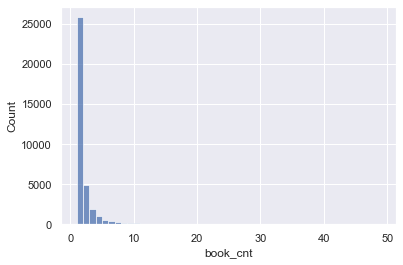

In [7]:
# count of books per author
books_per_author = pd.DataFrame.from_dict(Counter(items_df.loc[:,'author']),
                                    orient='index',
                                    columns=['book_cnt']).sort_values(by='book_cnt', ascending=False)
books_per_author['frac[%]'] = books_per_author['book_cnt'] * 100 / books_per_author['book_cnt'].sum()

print(f'# books per author:')
display(books_per_author.head(10))

print(f'summary statistics of books per author:')
display(books_per_author.describe())

# distribution of cnt af books among authors
books_per_author_cnts = pd.DataFrame(books_per_author['book_cnt'].value_counts().reset_index()).rename(columns={'index': 'book_cnt',
                                                                                                                'book_cnt': 'author_cnt'})
books_per_author_cnts['author_cnt.cum'] = books_per_author_cnts['author_cnt'].cumsum()
books_per_author_cnts['frac[%]'] = books_per_author_cnts['author_cnt'] * 100 / books_per_author_cnts['author_cnt'].sum()
books_per_author_cnts['frac.cum[%]'] = books_per_author_cnts['frac[%]'].cumsum()

print(f'distribution of books per author:')
display(books_per_author_cnts.head(10))
sns.set_theme()
sns.histplot(books_per_author[books_per_author['book_cnt']<50]['book_cnt'], binwidth=1)
plt.show()

#### publisher

# books per publisher:


,book_cnt,frac[%]
Books on Demand,3759,4.817378
LIGHTNING SOURCE INC,2355,3.018070
Lulu.com,1717,2.200436
Xlibris,1576,2.019736
Fichas de preescolar,1499,1.921056
iUniverse,1414,1.812124
epubli,1183,1.516084
INDEPENDENTLY PUBLISHED,1061,1.359733
AuthorHouse,1001,1.282840
Penguin Random House Children's UK,859,1.100859


summary statistics of books per publisher:


,book_cnt,frac[%]
count,7073.000000,7073.000000
mean,11.032094,0.014138
std,77.953138,0.099901
min,1.000000,0.001282
25%,1.000000,0.001282
50%,1.000000,0.001282
75%,4.000000,0.005126
max,3759.000000,4.817378


distribution of books per publisher:


,book_cnt,publisher_cnt,publisher_cnt.cum,frac[%],frac.cum[%]
0,1,3646,3646,51.548141,51.548141
1,2,1042,4688,14.732080,66.280221
2,3,514,5202,7.267072,73.547293
3,4,317,5519,4.481832,78.029125
4,5,228,5747,3.223526,81.252651
5,6,165,5912,2.332815,83.585466
6,7,115,6027,1.625901,85.211367
7,8,85,6112,1.201753,86.413120
8,9,79,6191,1.116924,87.530044
9,10,66,6257,0.933126,88.463170


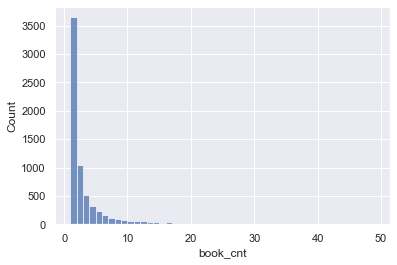

In [8]:
# count of books per publisher
books_per_publisher = pd.DataFrame.from_dict(Counter(items_df.loc[:,'publisher']),
                                    orient='index',
                                    columns=['book_cnt']).sort_values(by='book_cnt', ascending=False)
books_per_publisher['frac[%]'] = books_per_publisher['book_cnt'] * 100 / books_per_publisher['book_cnt'].sum()

print(f'# books per publisher:')
display(books_per_publisher.head(10))

print(f'summary statistics of books per publisher:')
display(books_per_publisher.describe())

# distribution of cnt af books among publishers
books_per_publisher_cnts = pd.DataFrame(books_per_publisher['book_cnt'].value_counts().reset_index()).rename(columns={'index': 'book_cnt',
                                                                                                                'book_cnt': 'publisher_cnt'})
books_per_publisher_cnts['publisher_cnt.cum'] = books_per_publisher_cnts['publisher_cnt'].cumsum()
books_per_publisher_cnts['frac[%]'] = books_per_publisher_cnts['publisher_cnt'] * 100 / books_per_publisher_cnts['publisher_cnt'].sum()
books_per_publisher_cnts['frac.cum[%]'] = books_per_publisher_cnts['frac[%]'].cumsum()

print(f'distribution of books per publisher:')
display(books_per_publisher_cnts.head(10))
sns.set_theme()
sns.histplot(books_per_publisher[books_per_publisher['book_cnt']<50]['book_cnt'], binwidth=1)
plt.show()

#### main topics

str len main topics:


,mt_len
count,77772.000000
mean,2.994355
std,0.746807
min,1.000000
25%,3.000000
50%,3.000000
75%,3.000000
max,10.000000


top 5 high level cats:


,Notation,book_cnt,frac[%],Category heading
0,Y,48416,62.047930,"Children’s, Teenage and Educational"
1,F,26534,34.004870,Fiction and Related items
2,X,934,1.196976,"Graphic novels, Comic books, Cartoons"
3,W,651,0.834295,"Lifestyle, Hobbies and Leisure"
4,D,409,0.524157,"Biography, Literature and Literary studies"


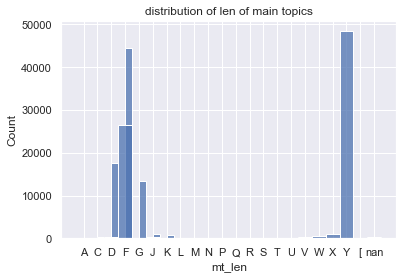

In [9]:
# get depth of main topic tree
print(f'str len main topics:')
display(pd.DataFrame(items_df["mt_len"].describe()))
mt_len_hist = sns.histplot(items_df['mt_len']).set_title(f'distribution of len of main topics')

# count of books per main topic (=mt) combo
books_per_mt = pd.DataFrame.from_dict(Counter(items_df.loc[:,'main topic']),
                                    orient='index',
                                    columns=['book_cnt']).sort_values(by='book_cnt', ascending=False)
books_per_mt['frac[%]'] = books_per_mt['book_cnt'] * 100 / books_per_mt['book_cnt'].sum()

# plot mt_0 distribution
sns.set_theme()
sns.histplot(items_df['mt_0'].astype(str).sort_values())

# count of books per first element of mt
books_per_mt_0 = pd.DataFrame.from_dict(Counter(items_df.loc[:,'mt_0']),
                                    orient='index',
                                    columns=['book_cnt']).sort_values(by='book_cnt', ascending=False).reset_index()
books_per_mt_0 = books_per_mt_0.rename(columns={'index': 'Notation'})
books_per_mt_0['frac[%]'] = books_per_mt_0['book_cnt'] * 100 / books_per_mt_0['book_cnt'].sum()

# join with category heading
books_per_mt_0 = books_per_mt_0.merge(subject_cats_0, on='Notation', how='left')
print(f'top 5 high level cats:')
display(books_per_mt_0.head(5))

### transactions

- basket: items that were added to basket but not necessarily bought
- order: items that where finally bought

In [10]:
# merge transactions with items to get title
transactions_df = transactions_df.merge(items_df[['itemID','title']], left_on='itemID', right_on='itemID', how='left')
transactions_df.head(5)

,sessionID,itemID,click,basket,order,click_flg,basket_flg,order_flg,title
0,0,21310,1,0,0,1,0,0,Princess Poppy: The Big Mix Up
1,1,73018,1,0,0,1,0,0,Einfach zeichnen! Step by Step
2,2,19194,1,0,0,1,0,0,Red Queen 1
3,3,40250,1,0,0,1,0,0,Meine Kindergarten-Freunde (Pirat)
4,4,46107,1,0,0,1,0,0,Mein großes Schablonen-Buch - Wilde Tiere


#### cnts per sessionID

In [11]:
# # get cnt of distinct item clicks per session
# unique_clicks_per_session = transactions_df[['sessionID', 'click_flg']].groupby('sessionID')['click_flg'].sum().reset_index().\
#     sort_values(by='click_flg', ascending=False)
# unique_clicks_per_session['frac[%]'] = unique_clicks_per_session['click_flg'] * 100 / unique_clicks_per_session['click_flg'].sum()
# unique_clicks_per_session = unique_clicks_per_session.rename(columns={'click_flg': '#clicked items unique'})

# print(f'clicked items per session:')
# display(round(unique_clicks_per_session.head(10),2))

# print(f'clicks per item summary stats:')
# display(round(unique_clicks_per_session.describe(),2))

# sns.boxplot(x=unique_clicks_per_session["#clicked items unique"])
# plt.show()

# # get cnt of distinctly ordered items per session
# orders_per_session = transactions_df[['sessionID', 'order_flg']].groupby('sessionID')['order_flg'].sum().reset_index().\
#     sort_values(by='order_flg', ascending=False).rename(columns={'order_flg': 'order_cnt'})
# orders_per_session['frac[%]'] = orders_per_session['order_cnt'] * 100 / orders_per_session['order_cnt'].sum()

# print(f'distinct orders per session (binary, w/o qty):')
# display(orders_per_session.head(10))

# print(f'distinct orders per session summary stats:')
# display(orders_per_session.describe())

# sns.boxplot(x=orders_per_session["order_cnt"])
# plt.show()

# # get cnt of distinct order sessions per item
# orders_per_item = transactions_df[['itemID', 'order_flg']].groupby('itemID')['order_flg'].sum().reset_index().\
#     sort_values(by='order_flg', ascending=False).rename(columns={'order_flg': 'order_cnt'})
# orders_per_item['frac[%]'] = orders_per_item['order_cnt'] * 100 / orders_per_item['order_cnt'].sum()

# # print(f'distinct orders per item (binary, w/o qty):')
# # display(orders_per_item.head(10))

# print(f'distinct orders per item summary stats:')
# display(orders_per_item.describe())

# get cnt of distinct orders / basket /orders per session
interaction_per_session = transactions_df[['sessionID',
                                           'click_flg',
                                           'basket_flg',
                                           'order_flg']].groupby('sessionID').sum().reset_index()
print(f'distribution of unique items clicked, added to basket, ordered:')
display(round(interaction_per_session[['click_flg','basket_flg','order_flg']].describe(),1).loc[['count','mean','std','25%','50%','75%','max']])

# get click to basket to order conversion
items_per_basket_order = transactions_df[['itemID',
                                          'click_flg',
                                          'basket_flg',
                                          'order_flg']].groupby(['click_flg',
                                                                 'basket_flg',
                                                                 'order_flg'])['itemID'].count().reset_index().rename(columns={'itemID': 'item_cnt'})
items_per_basket_order['frac[%]'] = items_per_basket_order['item_cnt'] * 100 / items_per_basket_order['item_cnt'].sum()
print(f'click to basket to order conversion:')
display(round(items_per_basket_order.sort_values(by=['click_flg','basket_flg','order_flg'],ascending=False),2))

distribution of unique items clicked, added to basket, ordered:


,click_flg,basket_flg,order_flg
count,271983.0,271983.0,271983.0
mean,1.3,0.2,0.1
std,1.6,0.7,0.3
25%,1.0,0.0,0.0
50%,1.0,0.0,0.0
75%,1.0,0.0,0.0
max,213.0,51.0,21.0


click to basket to order conversion:


,click_flg,basket_flg,order_flg,item_cnt,frac[%]
6,1,1,1,3692,1.01
5,1,1,0,30047,8.23
4,1,0,1,80,0.02
3,1,0,0,307776,84.29
2,0,1,1,835,0.23
1,0,1,0,10414,2.85
0,0,0,1,12299,3.37


#### top interaction items

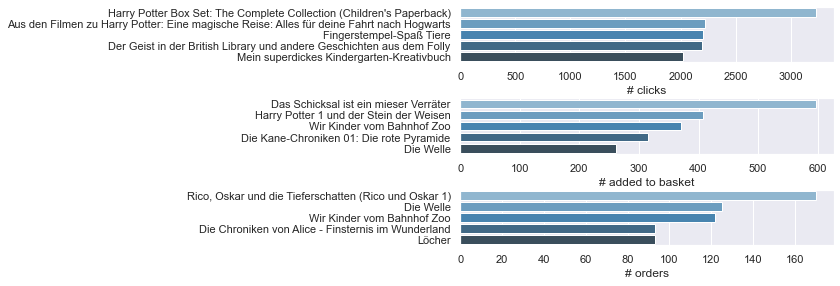

In [12]:
# get top sellers
top_interaction_items = transactions_df[['itemID', 'title',
                                         'click',
                                         'basket',
                                         'order']].groupby(['itemID','title']).sum().reset_index().sort_values(by='click')
top_clicked_items = top_interaction_items.sort_values(by='click',ascending=False).head(5)
top_basket_items = top_interaction_items.sort_values(by='basket',ascending=False).head(5)
top_order_items = top_interaction_items.sort_values(by='order',ascending=False).head(5)
# display(top_interaction_items.head(10))

# generate barplot
sns.set_theme()
fig, ax = plt.subplots(3,1)
plt.tight_layout()
sns.barplot(data=top_clicked_items,x='click',y='title',palette=palette_blue, ax=ax[0]).set(xlabel="# clicks",ylabel="")
sns.barplot(data=top_basket_items,x='basket',y='title',palette=palette_blue, ax=ax[1]).set(xlabel="# added to basket",ylabel="")
sns.barplot(data=top_order_items,x='order',y='title',palette=palette_blue, ax=ax[2]).set(xlabel="# orders",ylabel="")
plt.show()

# # get cnt of clicks per item
# clicks_per_item = transactions_df[['itemID', 'click']].groupby('itemID')['click'].sum().reset_index().\
#     sort_values(by='click', ascending=False).rename(columns={'click': 'click_cnt'})
# clicks_per_item['frac[%]'] = clicks_per_item['click_cnt'] * 100 / clicks_per_item['click_cnt'].sum()

# print(f'clicks per item:')
# display(clicks_per_item.head(10))

# print(f'clicks per item summary stats:')
# display(clicks_per_item.describe())

## Anomaly Detection

### Missing Values
- 9 items w/o publisher:
    - could be anything, cannot be imputed
    - not such a crucial information to be missing
    - thus: no handling
- 3240 items w/o author:
    - correct author might not be uniquely determinable or there might not even be a senseful author
    - thus: no handling
- 258 items w/o main topic:
    - at least subtopic is given
    - only 32 of these also have the author missing
- 36,904 items w/o subtopic:
    - in all of the cases, a main topic is given
    - thus: still enough information available

In [13]:
# get cnt of missing values per column
missing_values = pd.DataFrame(items_df.isnull().sum()).rename(columns={0: 'cnt'})
missing_values['frac[%]'] = missing_values['cnt'] * 100 / len(items_df)
print(f'null values per column:')
display(round(missing_values.loc[initial_cols + ["subtopics_str"]],2))

# get cnt of combined null values: sum null values per row and cnt rows with #null > 1
print(f'\n# rows with null values in more than one col: {(items_df[initial_cols + ["subtopics_str"]].isnull().sum(axis=1) > 1).sum()}')
print(f'\ndistribution of null values over cols (1=null, 0=not null):')
display(pd.DataFrame((items_df[initial_cols + ['subtopics_str']].isnull() * 1).value_counts().reset_index()).rename(columns={0: '#items'}))

null values per column:


KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['subtopics_str'], dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

#### Missing publisher

In [ ]:
# check all items with missing publisher
print('all items with missing publisher:')
display(items_df[items_df['publisher'].isnull()])

# check whether there might be other entries with publisher given
missing_publisher_title = items_df[items_df['publisher'].isnull()]['title']
print(f'books with same title that appear twice: {(items_df[items_df["title"].isin(missing_publisher_title)].groupby("title")["itemID"].count() > 1).sum()}\n')

# inspect sample with missing publisher
# > missing publisher is most likely to be 'TEKTIME' > however: could also be different
print('entries for title "Back to Earth" with missing publisher for some editions:')
display(items_df[items_df['title'].str.contains('Back to Earth')])
print('entries for author "Danilo Clementoni" with missing publisher for some items:')
display(items_df[items_df['author'] == 'Danilo Clementoni'])

#### Missing author
- __problem__:
    - there is a lot of items with very generalistic titles like 'Dinosaurier' or 'Die Weihnachtsgeschichte' that do not allow to uniquely determine the correct author
    - there might not even be a unique author, like for 'Freundebuch - Einhorn-Paradies - Meine Freunde' or 'Kritzkratz-Spaß Glitzer'
    - there might be the same item but several different authors, like for 'Goldilocks and the Three Bears'

- __approach__:
    - try to not impute author, use other attributes instead, e.g. topic or publisher

In [ ]:
# check all items with missing author
print('first 10 items with missing author:')
display(items_df[items_df['author'].isnull()].head(10))

# check whether there might be other entries with author given
missing_author_title = items_df[items_df['author'].isnull()]['title']
missing_author_cnt_dups = pd.DataFrame(items_df[items_df["title"].isin(missing_author_title)].groupby("title")["itemID"].count())
print(f'\nbooks with same title that appear twice (see df below): {(missing_author_cnt_dups["itemID"] > 1).sum()}')

# check whether author can be retried
missing_author_dups = missing_author_cnt_dups[missing_author_cnt_dups["itemID"] > 1].reset_index()['title']
display(items_df[items_df['title'].isin(missing_author_dups)].sort_values(by='title'))


#### Missing topic

In [ ]:
# check whether there are items with no topic at all
print(f'cnt of items with both, main topic and subtopic == null: {((items_df["subtopics_str"].isnull()) & (items_df["main topic"].isnull())).sum()}')

##### main

In [ ]:
# check all items with missing topic
print('first 10 items with missing topic:')
display(items_df[items_df['main topic'].isnull()].head(10))

# check whether there might be other entries with topic given
missing_topic_title = items_df[items_df['main topic'].isnull()]['title']
missing_topic_cnt_dups = pd.DataFrame(items_df[items_df["title"].isin(missing_topic_title)].groupby("title")["itemID"].count())
print(f'\nbooks with same title that appear twice (see df below): {(missing_topic_cnt_dups["itemID"] > 1).sum()}')

# check whether topic can be retried
missing_topic_dups = missing_topic_cnt_dups[missing_topic_cnt_dups["itemID"] > 1].reset_index()['title']
display(items_df[items_df['title'].isin(missing_topic_dups)].sort_values(by='title'))

# check cnt of items with main topic and subtopic missing


##### sub
- no scalable solution for imputing subtopics
- out of the 36,904 missing subtopics, only 2,668 items appear multiple times
    - out of these, only 1,574 actually have a duplicate with a subtopic given

In [ ]:
# check all items with missing topic
print('first 10 items with missing topic:')
display(items_df[items_df['subtopics_str'].isnull()])

# check whether there might be other entries with topic given
missing_topic_title = items_df[items_df['subtopics_str'].isnull()]['title']
missing_topic_cnt_dups = pd.DataFrame(items_df[items_df["title"].isin(missing_topic_title)].groupby("title")["itemID"].count())
print(f'\nbooks with same title that appear twice (see df below): {(missing_topic_cnt_dups["itemID"] > 1).sum()}')

# check whether topic can be retried
missing_topic_dups = missing_topic_cnt_dups[(missing_topic_cnt_dups["itemID"] > 1)].reset_index()['title']
display(items_df[(items_df['title'].isin(missing_topic_dups)) & (~items_df['subtopics_str'].isnull())].sort_values(by='title'))

### Duplicates

__To keep in mind:__
1. other relevant attributes are not given, e.g.:
    - actual __language__ might not be that of title
    - __publication date__ might differ between itemIDs (=Neuauflage)
    - title might not be complete (e.g. __subtitle__ missing)
        - e.g. '[Ära der Lichtwächter](https://www.amazon.com/s?k=%C3%84ra+der+Lichtw%C3%A4chter&ref=nb_sb_noss)' from 'Klaus Pfrommer' (itemID = (40200,18242)) is collection with differing subtitles "Die Täuschung", "Das Vermächtnis", "Die Unschuld"
    - thus: itemID would be unique identifier for actually different items
2. __transactions__ might help to differentiate between items and __rank their relevance__

#### duplicate entries per column

In [ ]:
# cnt column-wise duplication
sc_cnt = 1
total = len(items_df)
for col in initial_cols:
    dup_cnts = (items_df[col].value_counts() > 1).sum()
    print(f'cnt of duplicate {col}: {dup_cnts} ({round(dup_cnts*100/total,2)}%)')

# inspect title duplicates
title_cnts = (items_df["title"].value_counts().reset_index())
title_dups_lst = title_cnts[title_cnts["title"]>1]["index"]
items_df[(items_df["title"].isin(title_dups_lst))].sort_values(by="title")

#### everything identical except of single column
- only cases for duplicated items with same attributes but different itemID

In [ ]:
col_list = initial_cols #['itemID']
for col in col_list:

    # check all cols except of current one
    col_list_lim = [c for c in items_df.columns if c != col]
    #print(f'{col}: {col_list_lim}')

    # compute duplicate cnt
    dup = pd.DataFrame(items_df.groupby(col_list_lim)[col].count().reset_index())
    print(f'everything identical except of {col} = {(dup[col] > 1).sum()}')
    #display(dup[dup[col] > 1].sort_values(by=col))
    #display(dup.sort_values(by=col))

In [ ]:
# deep dive: everything identical except of ID
print(f'sample entry for sc1: everything identical except of itemID')
display(items_df[items_df['title']=='Reisestipendien'])